In [1068]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import poisson
from IPython.display import clear_output
import random
import datetime
import math

# DEFINE EASY Learning task

In [1092]:
class Problem:
    def __init__(self, submitter_address, x_train, y_train, x_test, y_test):
        self.submitter_address = submitter_address
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model_hashes = {}
        self.y_hats = {}
        self.losses = {}
        self.consensus = False
        
    def sendTrainDataToMiner(self, miner):
        miner.receiveTrainingData(self.x_train, self.y_train)
        
    def collectModelHashes(self, miner, _hash):
        self.model_hashes[miner] = _hash
        
    def sendXTestToMiner(self, miner):
        miner.receiveXTest(self.x_test)
        
    def collectYHat(self, miner, y_hat):
        self.y_hats[miner] = y_hat
        
    def computeTestLosses(self):
        for miner in self.y_hats:
            loss = 0
            for i in range(len(self.y_hats[miner])):
                loss += (self.y_test[i] - self.y_hats[miner][i])**2
            self.losses[miner] = loss
    
    def getMinerWithMinLoss(self):
        return min(self.losses, key=self.losses.get)
    
    def sendWinCertificate(self):
        winner = self.getMinerWithMinLoss()
        winner.receiveWinCertificate(self)
    
    def sendHashAndYHat(self, miner):
        winner = self.getMinerWithMinLoss()
        miner.receiveHashAndYHat(self.model_hashes[winner], self.y_hats[winner])
    
    def reportByzantineWinner(self, block):
        winner = block.miner
        func, w0, w1 = block.solution
        if hash(w0+w1) != self.model_hashes[winner]:
            if winner in self.losses.keys():
                del self.losses[winner]
            self.consensus = False
            return
        for i in range(len(self.y_hats[winner])):
            if self.y_hats[winner] != func(self.x_test[i], w0, w1):
                if winner in self.losses.keys():
                    del self.losses[winner]
                self.consensus = False
                return
        self.consensus = True          

# Utils

In [1093]:
def generateAddress():
    return hex(random.randint(0, 2**256))

# DEFINE NETWORK ENTITIES

In [1082]:
class Miner:
    def __init__(self, computing_power=1, protocol=Protocol):
        super(Miner, self).__init__()
        self.miner_address = generateAddress()
        self.local_history = []
        self.computing_power = 1
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_hat = None
        self.w0 = 0
        self.w1 = 0
        self.win_hash = None
        self.win_y_hat = None
    
    # THE FOLLOWING FUNCTIONS REPRESENT DIFFERENT STEPS OF THE PROTOCOL
    
    def receiveTrainingData(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    def predict(self, _x, _w0, _w1):
        return _w0 + _w1*_x
        
    def train(self):
        self.w0 = random.uniform(-1, 1) * 3
        self.w1 = random.uniform(-1, 1)
        self.alpha = random.uniform(0.0001, 0.02)        
        n = len(self.y_train)
        for i in range(ROUND_TIMEOUT):
            total_error = 0
            total_error_x = 0
            for j in range(n):
                y_pred = self.predict(self.x_train[j], self.w0, self.w1)
                total_error += self.y_train[j] - y_pred
                total_error_x += self.x_train[j] * (self.y_train[j] - y_pred)
            dw0 = (-2/n) * total_error
            dw1 = (-2/n) * total_error_x

            self.w0 = self.w0 - self.alpha*dw0
            self.w1 = self.w1 - self.alpha*dw1
            
    def sendModelHashToSubmitter(self, submitter):
        submitter.collectModelHashes(self, hash(self.w0+self.w1))
        
    def receiveXTest(self, x_test):
        self.x_test = x_test
        
    def predictYHat(self):
        self.y_hat = [None]*len(self.x_test)
        for i in range(len(self.x_test)):
            self.y_hat[i] = self.predict(self.x_test[i], self.w0, self.w1)
    
    def sendYHat(self, submitter):
        submitter.collectYHat(self, self.y_hat)
        
    def receiveWinCertificate(self, certificate):
        self.buildBlock(certificate)
        
    def buildBlock(self, certificate):
        block = Block([], (self.predict, self.w0, self.w1), hash(str(self.local_history[-1].data)), certificate, miner=self)
        self.local_history.append(block)
        
    def broadcastBlock(self, net):
        for miner in net.miners:
            if miner != self:
                miner.confirmBlock(self.local_history[-1])
            
    def receiveHashAndYHat(self, win_hash, win_y_hat):
        self.win_hash = win_hash
        self.win_y_hat = win_y_hat
            
    def confirmBlock(self, block):
        try:
            func, w0, w1 = block.solution
            submitter = block.submitter
            if hash(w0+w1) != self.win_hash:
                submitter.reportByzantineWinner(block)
            for i in range(len(self.win_y_hat)):
                if self.win_y_hat[i] != func(self.x_test[i], w0, w1):
                    submitter.reportByzantineWinner(block)
        except:
            return submitter.reportByzantineWinner(block)
        self.local_history.append(block)        
            
    def initRound(self):
        self.w0 = 0
        self.w1 = 0
        self.alpha = 0
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_hat = None
        self.win_hash = None
        self.win_y_hat = None


In [1083]:
class Submitter:
    def __init__(self):
        super(Submitter, self).__init__()
        self.submitter_address = generateAddress()

In [1094]:
class ByzantineMiner (Miner, Submitter):
    def __init__(self):
        super(ByzantineMiner, self).__init__()
        
    def buildBlock(self, certificate):
        block = Block([], (self.predict, 3, 2), hash(str(self.local_history[-1].data)), certificate, miner=self)
        self.local_history.append(block)

In [1095]:
class Client:
    def __init__(self):
        super(Client, self).__init__()
        self.client_address = generateAddress()
        
    def generateTransaction():
        pass

In [1096]:
class Block:
    def __init__(self, data, solution, previous_hash, submitter, miner=hex(0)):
        self.data = data #transactions
        self.miner = miner
        self.reward = 2.5
        self.previous_hash = previous_hash
        self.submitter = submitter
        self.solution = solution
        self.timestamp = datetime.datetime.now()
        self.nonce = 0
        #self.hash = self.generate_hash()

In [1097]:
class GenesisBlock(Block):
    def __init__(self, data):
        super(GenesisBlock, self).__init__(data, None, None, None)

In [1098]:
class Transaction:
    def __init__(self, sender, receiver, amount):
        super(Transaction, self).__init__()
        self.sender = sender
        self.receiver = receiver
        self.amount = amount
        
class Mint(Transaction):
    def __init__(self, receiver, amount):
        super(Mint, self).__init__(hex(0), receiver, amount)

In [1099]:
class Network:
    def __init__(self, n=1, f=0):
        self.n = n # total number of nodes
        self.f = f # total number of dishonest nodes
        self.longest_chain = [GenesisBlock("GenesisBlock")]
        self.honest_miners = [Miner() for i in range(n-f)]
        self.dishonest_miners = [ByzantineMiner() for i in range(f)]
        self.miners = self.honest_miners + self.dishonest_miners
        for miner in self.miners:
            miner.local_history = self.longest_chain[:]
        self.problem_pool = []
        self.transaction_pool = []
        
    def submitProblem(self, problem):
        self.problem_pool.append(problem)
        
    def getProblem(self):
        return self.problem_pool.pop(0)
    
    def updateLongestChain(self):
        longest_size = 0
        for miner in self.miners:
            if len(miner.local_history) > longest_size:
                self.longest_chain = miner.local_history[:]
                
    def fillPoolWithRandomTransactions(self, n_txs=1000):
        for i in range(n_txs):
            self.transaction.pool.append(Transaction(generateAddress(),generateAddress(),random.randint(0, 12)))
            
    def getBalance(self, address):
        balance = 0
        for block in self.longest_chain:
            if type(block)==type(GenesisBlock("")): continue
            if address == block.miner.miner_address:
                balance += block.reward
            for tx in block.data:
                if address == tx.sender:
                    balance -= tx.amount
                if address == tx.receiver:
                    balance += tx.amount
        return balance

# DEFINE WORLD

Round 960


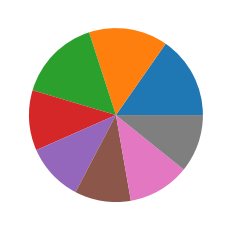

In [1112]:
MAX_ROUNDS = 1000
ROUND_TIMEOUT = 500 #number of train epochs before comparing model accuracies

net = Network(n=5, f=2)

for i in range(MAX_ROUNDS):
    net.submitProblem(Problem(Submitter().submitter_address,
                              x_train = [0, 2, 5, 1, 7, 9, 2, 3, 1, 0.5],
                              y_train = [7, 8, 4, 9, 2, 0, 4, 6, 9, 6],
                              x_test = [0.5, 2.1, 4.2, 0.6, 7.1, 9.2, 1, 3, 1],
                              y_test = [6, 8, 3, 10, 2.2, 0.1, 3.2, 6.1, 8.8]))

n_problems = len(net.problem_pool)
for r in range(n_problems):
    #print(f"--START OF ROUND {r}--")
    #print("-Training Phase-")

    #print("   Submitter sending train data to miners")
    submitter_r = net.getProblem()
    for miner in net.miners:
        submitter_r.sendTrainDataToMiner(miner)
    
    #print("   Miners training...")
    for miner in net.miners:
        miner.train()
    #print("   Training timeout")

    #print("   Miners sending model hashes to submitter")
    for miner in net.miners:
        miner.sendModelHashToSubmitter(submitter_r)
   
    #print("-Evaluation Phase-")
    #print("   Submitter broadcasting X_test")
    for miner in net.miners:
        submitter_r.sendXTestToMiner(miner)
        
    #print("   Miners predicting Y_test^hat")
    for miner in net.miners:
        miner.predictYHat()
    
    #print("   Miners sending Y_test^hat to submitter")
    for miner in net.miners:
        miner.sendYHat(submitter_r)
    
    #print("   Submitter computing losses")
    submitter_r.computeTestLosses()
    
    #print("-Awarding phase-")
    while len(submitter_r.losses)>0 and not submitter_r.consensus:
        submitter_r.consensus = True
        winner = submitter_r.getMinerWithMinLoss()
        #print("   Miner with a greater model:",winner)
        #print("   Submitter sending signed certificate of win")
        submitter_r.sendWinCertificate()
        #print("   Submitter broadcasting info to miners to validate Block")
        for miner in net.miners:
            submitter_r.sendHashAndYHat(miner)
        #print("   Winner broadcasting Block")
        winner.broadcastBlock(net)
    
    #print(f"--END OF ROUND {r}--\n")
    net.updateLongestChain()
    #print(net.longest_chain, "\n")
    
    miner_balances = [net.getBalance(net.miners[i].miner_address) for i in range(net.n)]
    plt.ion()
    if sum(miner_balances) != 0:
        if r%40 == 0:
            clear_output(wait=True)
            print("Round", r)
            fig, ax = plt.subplots()
            ax.pie(miner_balances)
            plt.pause(0.002)
            plt.show()

# Plot balances

In [1113]:
miner_balances = [net.getBalance(net.miners[i].miner_address) for i in range(net.n)]
print(miner_balances)
print(net.miners)

[842.5, 820.0, 837.5, 622.5, 595.0, 577.5, 625.0, 587.5]
[<__main__.Miner object at 0x000002550808FF70>, <__main__.Miner object at 0x000002550808F250>, <__main__.Miner object at 0x000002550808F0A0>, <__main__.ByzantineMiner object at 0x000002550808FB50>, <__main__.ByzantineMiner object at 0x000002550808FDC0>, <__main__.ByzantineMiner object at 0x000002550808F7F0>, <__main__.ByzantineMiner object at 0x000002550808F4C0>, <__main__.ByzantineMiner object at 0x000002550808FB20>]


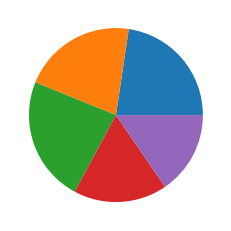

In [1108]:
if sum(miner_balances) != 0:
    fig, ax = plt.subplots()
    ax.pie(miner_balances)
    plt.show()

In [1000]:
net = Network(n=5, f=2)
random_guy = generateAddress()
print(random_guy)
print(net.getBalance(random_guy))
net.longest_chain.append(Block([Mint(random_guy, 20)], 0, 0, net.miners[4].miner_address))
net.longest_chain.append(Block([], 0, 0, net.miners[2].miner_address))
net.longest_chain.append(Block([], 0, 0, net.miners[1].miner_address))
net.longest_chain.append(Block([], 0, 0, net.miners[3].miner_address))
net.longest_chain.append(Block([], 0, 0, net.miners[4].miner_address))
print(net.getBalance(random_guy))

0xd41559fddb2d09b6639a13719e48e8b7e1f5dd21ea8846284bd209d22c431303
0
20


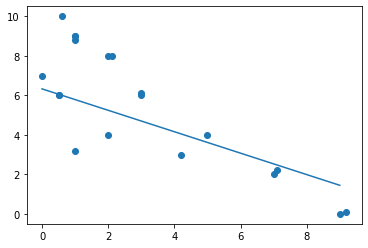

In [679]:
x = [0, 2, 5, 1, 7, 9, 2, 3, 1, 0.5, 0.5, 2.1, 4.2, 0.6, 7.1, 9.2, 1, 3, 1]
y = [7, 8, 4, 9, 2, 0, 4, 6, 9, 6, 6, 8, 3, 10, 2.2, 0.1, 3.2, 6.1, 8.8]

plt.scatter(x, y)
plt.plot([net.miners[0].w0 + net.miners[0].w1*i for i in range(int(min(x)), int(max(x))+1)])
plt.show()

In [656]:
def predict(_x, _w0, _w1):
    return _w0 + _w1*_x
       
x_train = [0, 2, 5, 1, 7, 9, 2, 3, 1, 0.5]
y_train = [7, 8, 4, 9, 2, 0, 4, 6, 9, 6]

w0 = -1
w1 = 2
alpha = 0.01 #random.uniform(0.0001, 0.02)        
n = len(y_train)
for i in range(1000):
    total_error = 0
    total_error_x = 0
    for j in range(n):
        y_pred = predict(x_train[j], w0, w1)
        total_error += y_train[j] - y_pred
        total_error_x += x_train[j] * (y_train[j] - y_pred)
    dw0 = (-2/n) * total_error
    dw1 = (-2/n) * total_error_x

    w0 -= alpha*dw0
    w1 -= alpha*dw1
    
print(w0, w1)

8.155595731695442 -0.8708453521697761
